QAOA_transfer_subgraphs_4Eesh.ipynb

## Basics

In [1]:
#!sudo apt install libglpk-dev python3.8-dev libgmp3-dev

In [2]:
#!pip install picos

In [3]:
#!pip install git+https://github.com/bluesurfer/maxCutPy.git@master

In [7]:
import warnings
warnings.filterwarnings('ignore')

import time
import os
import numpy as np
import scipy.optimize
from scipy.optimize import minimize
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
import random
import matplotlib.pyplot as plt
import scipy.stats as ss
import math
import copy
import networkx
import networkx as nx
from datetime import datetime
import csv 
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import ast
import re
from networkx.linalg.spectrum import laplacian_spectrum
from itertools import product

#!pip install nlopt
#!pip install quimb
#!pip install autoray
#!pip install pytorch
#!pip install cotengra
# !pip install quimb autoray git+https://github.com/jcmgray/cotengra
# !pip install cartesian_explorer
import nlopt

from qtensor import parameter_optimization as popt
import torch


In [8]:
from qtensor import QAOA_energy
#from qtensor.optimisation.Optimizer import TamakiOptimizer
#from qtensor.optimisation.Optimizer import OrderingOptimizer
from qtensor.optimisation.Optimizer import WithoutOptimizer
from qtensor.optimisation.TensorNet import QtreeTensorNet
from qtensor import QtreeQAOAComposer
from qtensor import QAOAQtreeSimulator

In [9]:
import networkx as nx
import qtensor
from cartesian_explorer import Explorer
import matplotlib.pyplot as plt

# results

In [12]:
from matplotlib import pyplot
from matplotlib import gridspec

def get_qaoa_params(graph, edge=None, gamma=[0.5], beta=[0.5], steps=50):
    loss_history, params_history = popt.qaoa_maxcut_torch(graph, gamma, beta,
                                                          ordering_algo='greedy',
                                                          Opt=torch.optim.RMSprop,
                                                          edge=edge,
                                                          opt_kwargs=dict(lr=0.002),
                                                          steps=steps,
                                                          pbar=False)
    best_ix = np.argmin(loss_history)
    return params_history[best_ix], loss_history[best_ix]

def get_edge_contribution(graph, edge, gamma, beta):
    sim = qtensor.QtreeSimulator()
    composer = qtensor.DefaultQAOAComposer(graph, gamma=gamma, beta=beta)
    composer.energy_expectation_lightcone(edge)
    return np.real(sim.simulate_batch(composer.circuit)[0])

def transferability_matrix(graphs, multistart=10, steps=100):
    sim = WithoutQAOASimulator(QtreeQAOAComposer)
    matrix_loss = np.zeros((len(graphs), len(graphs)))
    for i, donor in enumerate(graphs):
        print(f"{i + 1}/{len(graphs)}")
        for s in range(multistart):
            gamma, beta = [np.random.rand()], [np.random.rand()]
            params, loss = get_qaoa_params(donor, edge=(0,1), gamma=gamma, beta=beta, steps=steps)
            gamma_opt, beta_opt = params[0][0], params[1][0]
            for j, acceptor in enumerate(graphs):
                trloss = get_edge_contribution(acceptor, (0,1), *params)
                similarity = trloss*loss/np.sqrt(trloss**2 + loss**2 + 0.001)
                matrix_loss[i,j] += similarity
    return matrix_loss

def transferability_matrix_list(graphs, multistart=10, steps=100):
    sim = WithoutQAOASimulator(QtreeQAOAComposer)
    matr = [[[0 for k in range(2)] for j in range(len(graphs))] for i in range(len(graphs))]
    #print(matr)
    for i, donor in enumerate(graphs):
        print(f"{i + 1}/{len(graphs)}")
        for s in range(multistart):
            gamma, beta = [np.random.rand()], [np.random.rand()]
            params, loss = get_qaoa_params(donor, edge=(0,1), gamma=gamma, beta=beta, steps=steps)
            gamma_opt, beta_opt = params[0][0], params[1][0]
            for j, acceptor in enumerate(graphs):
                trloss = get_edge_contribution(acceptor, (0,1), *params)
                matr[i][j] = [matr[i][j][0] + loss, matr[i][j][1] + trloss]

    for i in range(len(graphs)):
        for j in range(len(graphs)):
            matr[i][j] = [matr[i][j][0]/multistart, matr[i][j][1]/multistart]
    return matr

def transferability_matrix_all_data(graphs, multistart=10, steps=100, average=True):
    sim = WithoutQAOASimulator(QtreeQAOAComposer)
    matr = [[[[], [], [], []] for j in range(len(graphs))] for i in range(len(graphs))]
    #print(matr)
    for i, donor in enumerate(graphs):
        print(f"{i + 1}/{len(graphs)}")
        for s in range(multistart):
            gamma, beta = [np.random.rand()], [np.random.rand()]
            params, loss = get_qaoa_params(donor, edge=(0,1), gamma=gamma, beta=beta, steps=steps)
            gamma_opt, beta_opt = params[0][0], params[1][0]
            for j, acceptor in enumerate(graphs):
                loss_donor = get_edge_contribution(donor, (0,1), *params)
                loss_acceptor = get_edge_contribution(acceptor, (0,1), *params)
                en_donor = (1 - loss_donor)/2
                en_acceptor = (1 - loss_acceptor)/2
                #matr[i][j][0] += [[gamma_opt, beta_opt]]
                #print(matr[i][j][1])
                matr[i][j][0] += [en_donor]
                matr[i][j][1] += [en_acceptor]

    if average:
        for i in range(len(graphs)):
            for j in range(len(graphs)):
                matr[i][j][2] = [np.max(matr[i][j][0])]
                matr[i][j][3] = [np.max(matr[i][j][1])]
                matr[i][j][0] = [np.mean(matr[i][j][0])]
                matr[i][j][1] = [np.mean(matr[i][j][1])]
    return matr

def transferability_matrix_energy(graphs, multistart=10, steps=100):
    sim = WithoutQAOASimulator(QtreeQAOAComposer)
    matrix_energy = np.zeros((len(graphs), len(graphs)))
    for i, donor in enumerate(graphs):
        print(f"{i + 1}/{len(graphs)}")
        for s in range(multistart):
            gamma, beta = [np.random.rand()], [np.random.rand()]
            params, loss = get_qaoa_params(donor, gamma=gamma, beta=beta, steps=steps)
            gamma_opt, beta_opt = params[0][0], params[1][0]
            for j, acceptor in enumerate(graphs):
                en = sim.energy_expectation_parallel(acceptor, gamma=[gamma_opt], beta=[beta_opt], n_processes=4)[0]
                matrix_energy[i,j] += en
    return matrix_energy

def sub_all(d1, d2, draw=False):
    A = np.zeros((d1 + d2, d1 + d2))
    A[d1 + 1:, d1] = 1
    A[:d1 - 1, d1 - 1] = 1
    A[d1 - 1, :d1 - 1] = 1
    A[d1, d1 + 1:] = 1
    A[d1, d1 - 1] = 1
    A[d1 - 1, d1] = 1
    
    g = nx.from_numpy_matrix(np.array(A))

    g_list = [g]
    for i in range(min(d1, d2) - 1):
        g = g_list[i]
        g_list.append(nx.contracted_nodes(g, i, i + d1 + 1))
    # relabel center edge as (0, 1)
    for i, g in enumerate(g_list):
        g_list[i] = qtensor.tools.lightcone_orbits.relabel_edge_first(g, (d1 - 1, d1))
        if draw:
            nx.draw_kamada_kawai(g)
            plt.show()
    return g_list

**reg data**

In [11]:
# d_min = 1
# d_max = 8
# g_all = []
# d_dict = {}
# for i in range(d_min, d_max + 1):
#     #print(i,j)
#     g_sub_ij = sub_all(i, i)
#     g_all += g_sub_ij
#     d_dict[f"({i})"] = len(g_sub_ij)
# print(len(g_all))
# print(d_dict)

In [ ]:
mat_all_data = transferability_matrix_all_data(g_all, multistart=20, steps=200)#, average=False)

In [ ]:
mat_all_data

**mixed degree data**

In [ ]:
d_min = 1
d_max = 6
g_all = []
d_dict = {}
for i in range(d_min, d_max + 1):
    for j in range(i, d_max + 1):
        #print(i,j)
        g_sub_ij = sub_all(i, j)
        g_all += g_sub_ij
        d_dict[f"({i},{j})"] = len(g_sub_ij)
print(len(g_all))
print(d_dict)

50
{'(2,2)': 2, '(2,3)': 2, '(2,4)': 2, '(2,5)': 2, '(2,6)': 2, '(3,3)': 3, '(3,4)': 3, '(3,5)': 3, '(3,6)': 3, '(4,4)': 4, '(4,5)': 4, '(4,6)': 4, '(5,5)': 5, '(5,6)': 5, '(6,6)': 6}


In [ ]:
mat_all_data = transferability_matrix_all_data(g_all, multistart=20, steps=200)#, average=False)

In [ ]:
mat_all_data

###load results

In [18]:
# more general subgraphs: 50 restarts, 500 steps each, graphs with 1-6 node degrees
#fin = open("/content/mat_all_data_1-6_50_500.py", 'r')

# regular subgraphs: 50 restarts, 500 steps each, graphs with 1-6 node degrees
fin = open("/content/mat_all_data_reg_1-8_50_500.py", 'r')

body = fin.read().split("\n")
total = ''
for line in body:
    total = total + line
exec(total)

In [22]:
mat = np.zeros((len(g_all), len(g_all)))
for i in range(len(mat_all_data)):
    for j in range(len(mat_all_data[0])):
        mat[i, j] = mat_all_data[i][j][1][0]/np.max(np.array(mat_all_data)[:,j,3])

### analysis

In [23]:
mat_norm = np.zeros((len(g_all), len(g_all)))
for i in range(len(g_all)):
    for j in range(len(g_all)):
        mat_norm[i, j] += mat[i, j]/np.max(mat[:,j])

In [24]:
vmin = 0
mat_cut = np.zeros((len(g_all), len(g_all)))
for i in range(len(g_all)):
    for j in range(len(g_all)):
        if mat[i, j] > 0:
            mat_cut[i, j] += mat[i, j]
        #else:
        #    mat_cut[i, j] += vmin #np.nan

In [25]:
vmax = np.max(mat)
vmin = np.min(mat)
print(vmax)
print(vmin)

0.9999999922195681
0.3748395241237924


swap donor and acceptor for the plot

In [27]:
list(d_dict.values())

[1, 2, 3, 4, 5, 6, 7, 8]

In [33]:
sub_labels = []
for i, item in enumerate(list(d_dict.keys())):
    sub_labels += [item]*list(d_dict.values())[i]

In [34]:
def subgraph_list(g, draw=False, dist=1):
    g_sub_list = []
    subgraphs = [qtensor.utils.get_edge_subgraph(g, e, dist) for e in g.edges]
    for g_sub in subgraphs:
        if len(g_sub_list) > 0:
            if not any([nx.is_isomorphic(g_sub, g_i) for g_i in g_sub_list]):
                g_sub_list.append(g_sub)
                if draw:
                    nx.draw_kamada_kawai(g_sub)
                    plt.show()
        else:                  
            g_sub_list.append(g_sub)
            if draw:
                nx.draw_kamada_kawai(g_sub)
                plt.show()
    return g_sub_list

def match_idx(subgraphs, full_list):
    match_idx = []
    for sub in subgraphs:
        for i, sub_all in enumerate(full_list):
            if nx.is_isomorphic(sub, sub_all):
                match_idx.append(i)
    return np.sort(match_idx).tolist()

def is_transferable(donor_idx, acceptor_idx, transferability_matrix, upper=1, lower=-1):
    coeffs = []
    for i in donor_idx:
        for j in acceptor_idx:
            if transferability_matrix[i, j] > upper:
                coeffs.append(1)
            elif transferability_matrix[i, j] < lower:
                coeffs.append(-1)
            else:
                coeffs.append(0)
    outcome = 0
    if np.sum(coeffs) == len(coeffs):
        outcome = 1
    elif np.sum(coeffs) == -len(coeffs):
        outcome = -1
    return outcome

def highlight_cell(x, y, j1, j2, ax=None, **kwargs):
    rect = plt.Rectangle((x - 0.5, y - 0.5), j1, j2, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

def plot_heatmap(idx_donor=[], idx_acceptor=[], vmax=np.max(mat), vmin=np.min(mat), plot_subgraphs=False):
    d_list = list(d_dict.values())
    tick_list = [sum(d_list[0:i]) + d_list[i]/2 - 0.5 for i in range(len(d_list))]

    #vmax = 0.5   #np.max(mat)
    #vmin = -vmax #np.min(mat)

    fig = pyplot.figure(figsize=(20, 16))

    n1 = 10
    n2 = 20
    n3 = 30
    n4 = 40
    n5 = 50

    if plot_subgraphs:
        gs0 = gridspec.GridSpec(6, 1, height_ratios=[3, 1, 1, 1, 1, 1])
        gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
        gs01 = gridspec.GridSpecFromSubplotSpec(1, n1 + 1, subplot_spec=gs0[1])
        gs02 = gridspec.GridSpecFromSubplotSpec(1, n2 - n1 + 1, subplot_spec=gs0[2])
        gs03 = gridspec.GridSpecFromSubplotSpec(1, n3 - n2 + 1, subplot_spec=gs0[3])
        gs04 = gridspec.GridSpecFromSubplotSpec(1, n4 - n3 + 1, subplot_spec=gs0[4])
        gs05 = gridspec.GridSpecFromSubplotSpec(1, n5 - n4 + 1, subplot_spec=gs0[5])
    else:    
        gs0 = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
        gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])

    ax_mat = fig.add_subplot(gs0[0])
    plt.sca(ax_mat)

    f = plt.imshow(np.transpose(mat), cmap='RdBu', vmax=vmax, vmin=vmin)
    plt.xticks(tick_list, labels=list(d_dict.keys()))
    plt.yticks(tick_list, labels=list(d_dict.keys()))
        
    plt.colorbar(f, shrink=1)
    plt.title('Subgraph parameter transferability (p=1)', fontsize=20)
    plt.ylabel('Acceptor subgraph', fontsize=16)
    plt.xlabel('Donor subgraph', fontsize=16)

    for i in [sum(d_list[0:i]) - 0.5 for i in range(len(d_list))]:
        plt.axvline(x=i, color='black', linestyle='--', linewidth=2)
        plt.axhline(y=i, color='black', linestyle='--', linewidth=2)

    for j2, i2 in enumerate([sum(d_list[0:(list(d_dict.keys()).index(f'({k},{k})'))]) for k in range(2,7)]):
        for j1, i1 in enumerate([sum(d_list[0:(list(d_dict.keys()).index(f'({k},{k})'))]) for k in range(2,7)]):
            highlight_cell(i1, i2, j1 + 2, j2 + 2, color="black", linewidth=3)

    for i1 in idx_donor:  
        for i2 in idx_acceptor:  
            highlight_cell(i1, i2, 1, 1, color="red", linewidth=3)    

    if plot_subgraphs:
        for i, g in enumerate(g_all[0:n1]):
            ax00 = fig.add_subplot(gs01[i])
            plt.sca(ax00)
            plt.title(f'{i}\n{sub_labels[i]}')
            plt.margins(0.2, 0.2)
            nx.draw_kamada_kawai(g, node_size=20)

        for i in range(n1, n2):
            g = g_all[i]
            ax00 = fig.add_subplot(gs02[i - n1])
            plt.sca(ax00)
            plt.title(f'{i}\n{sub_labels[i]}')
            plt.margins(0.2, 0.2)
            nx.draw_kamada_kawai(g, node_size=20)

        for i in range(n2, n3):
            g = g_all[i]
            ax00 = fig.add_subplot(gs03[i - n2])
            plt.sca(ax00)
            plt.title(f'{i}\n{sub_labels[i]}')
            plt.margins(0.2, 0.2)
            nx.draw_kamada_kawai(g, node_size=20)

        for i in range(n3, n4):
            g = g_all[i]
            ax00 = fig.add_subplot(gs04[i - n3])
            plt.sca(ax00)
            plt.title(f'{i}\n{sub_labels[i]}')
            plt.margins(0.2, 0.2)
            nx.draw_kamada_kawai(g, node_size=20)

        for i in range(n4, n5):
            g = g_all[i]
            ax00 = fig.add_subplot(gs05[i - n4])
            plt.sca(ax00)
            plt.title(f'{i}\n{sub_labels[i]}')
            plt.margins(0.2, 0.2)
            nx.draw_kamada_kawai(g, node_size=20)
        plt.tight_layout()

def plot_heatmap_reg(idx_donor=[], idx_acceptor=[], vmax=np.max(mat), vmin=np.min(mat), plot_subgraphs=False):
    d_list = list(d_dict.values())
    tick_list = [sum(d_list[0:i]) + d_list[i]/2 - 0.5 for i in range(len(d_list))]

    #vmax = 0.5   #np.max(mat)
    #vmin = -vmax #np.min(mat)

    fig = pyplot.figure(figsize=(20, 16))

    n1 = 10
    n2 = 20
    n3 = 30
    n4 = 40
    n5 = 50

    if plot_subgraphs:
        gs0 = gridspec.GridSpec(6, 1, height_ratios=[3, 1, 1, 1, 1, 1])
        gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
        gs01 = gridspec.GridSpecFromSubplotSpec(1, n1 + 1, subplot_spec=gs0[1])
        gs02 = gridspec.GridSpecFromSubplotSpec(1, n2 - n1 + 1, subplot_spec=gs0[2])
        gs03 = gridspec.GridSpecFromSubplotSpec(1, n3 - n2 + 1, subplot_spec=gs0[3])
        gs04 = gridspec.GridSpecFromSubplotSpec(1, n4 - n3 + 1, subplot_spec=gs0[4])
        gs05 = gridspec.GridSpecFromSubplotSpec(1, n5 - n4 + 1, subplot_spec=gs0[5])
    else:    
        gs0 = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
        gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])

    ax_mat = fig.add_subplot(gs0[0])
    plt.sca(ax_mat)

    f = plt.imshow(np.transpose(mat), cmap='RdBu', vmax=vmax, vmin=vmin)
    plt.xticks(tick_list, labels=list(d_dict.keys()))
    plt.yticks(tick_list, labels=list(d_dict.keys()))
        
    plt.colorbar(f, shrink=1)
    plt.title('Subgraph parameter transferability (p=1)', fontsize=20)
    plt.ylabel('Acceptor subgraph', fontsize=16)
    plt.xlabel('Donor subgraph', fontsize=16)

    for i in [sum(d_list[0:i]) - 0.5 for i in range(len(d_list))]:
        plt.axvline(x=i, color='black', linewidth=2)
        plt.axhline(y=i, color='black', linewidth=2)

    for i1 in idx_donor:  
        for i2 in idx_acceptor:  
            highlight_cell(i1, i2, 1, 1, color="red", linewidth=3)    

    if plot_subgraphs:
        for i, g in enumerate(g_all[0:n1]):
            ax00 = fig.add_subplot(gs01[i])
            plt.sca(ax00)
            plt.title(f'{i}\n{sub_labels[i]}')
            plt.margins(0.2, 0.2)
            nx.draw_kamada_kawai(g, node_size=20)

        for i in range(n1, n2):
            g = g_all[i]
            ax00 = fig.add_subplot(gs02[i - n1])
            plt.sca(ax00)
            plt.title(f'{i}\n{sub_labels[i]}')
            plt.margins(0.2, 0.2)
            nx.draw_kamada_kawai(g, node_size=20)

        for i in range(n2, n3):
            g = g_all[i]
            ax00 = fig.add_subplot(gs03[i - n2])
            plt.sca(ax00)
            plt.title(f'{i}\n{sub_labels[i]}')
            plt.margins(0.2, 0.2)
            nx.draw_kamada_kawai(g, node_size=20)

        for i in range(n3, n4):
            g = g_all[i]
            ax00 = fig.add_subplot(gs04[i - n3])
            plt.sca(ax00)
            plt.title(f'{i}\n{sub_labels[i]}')
            plt.margins(0.2, 0.2)
            nx.draw_kamada_kawai(g, node_size=20)

        for i in range(n4, n5):
            g = g_all[i]
            ax00 = fig.add_subplot(gs05[i - n4])
            plt.sca(ax00)
            plt.title(f'{i}\n{sub_labels[i]}')
            plt.margins(0.2, 0.2)
            nx.draw_kamada_kawai(g, node_size=20)
        plt.tight_layout()

**general**

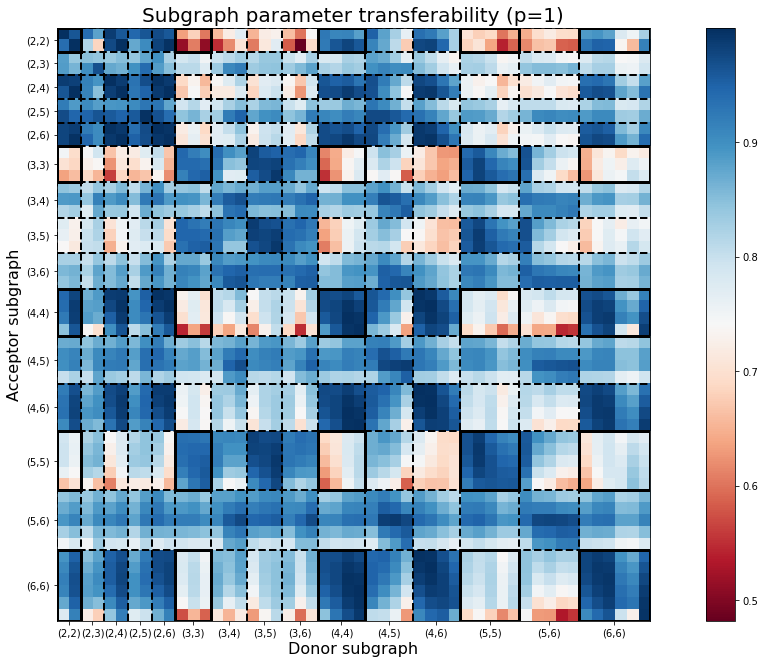

In [ ]:
plot_heatmap()#vmax=4, plot_subgraphs=False)

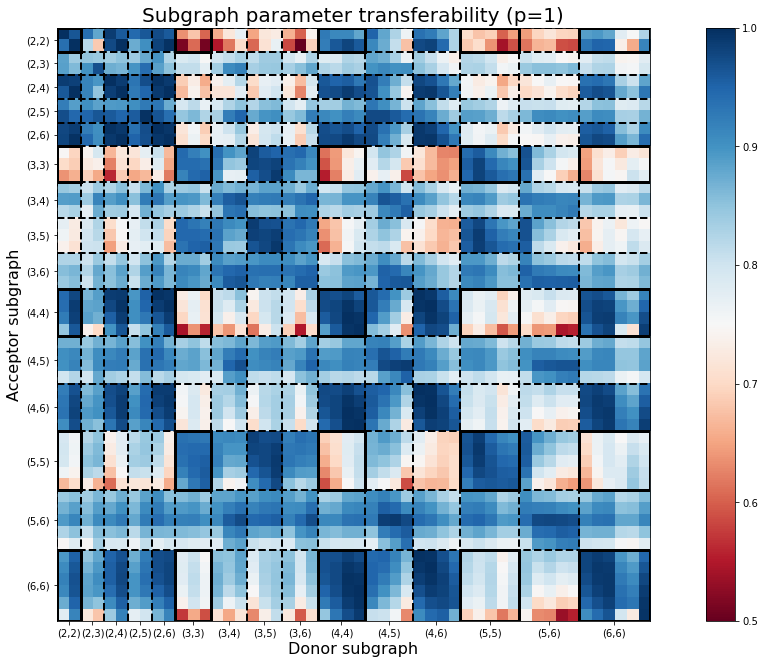

In [ ]:
plot_heatmap(vmax=1, vmin=0.5)

**regular**

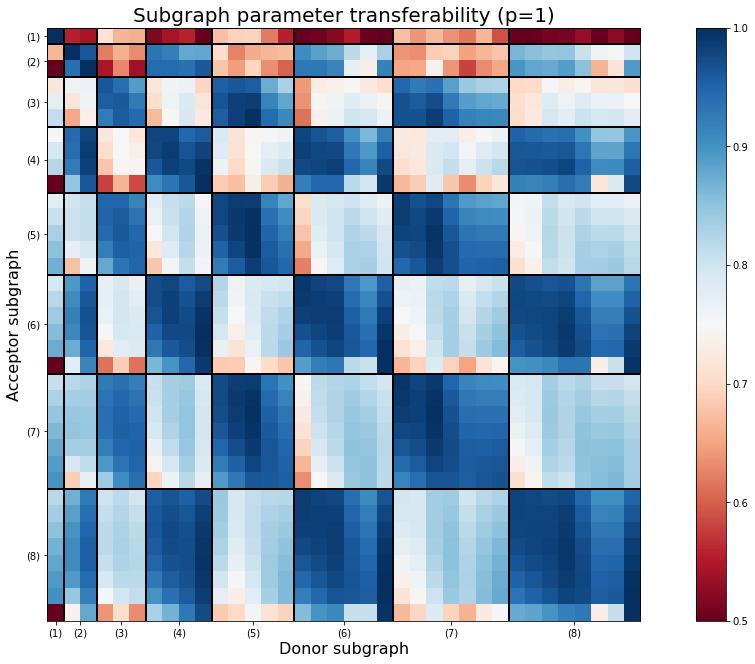

In [35]:
plot_heatmap_reg(vmax=1, vmin=0.5)